# UDLF Non-Local Means (CPRR)
Images and data collected from experiments of UDLF Non-Local Means with CPRR as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

from parameters import *
from utils import *

## Parameters

In [2]:
# UDLF Parameters
udl_method = 'CPRR'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

CPRR {'k': 3, 't': 1}


In [3]:
parent_dir = os.path.join('.', 'output', 'final_tests', f'{udl_method}_{seed}')
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

./output/final_tests/CPRR_42/disk


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

<Figure size 640x480 with 0 Axes>

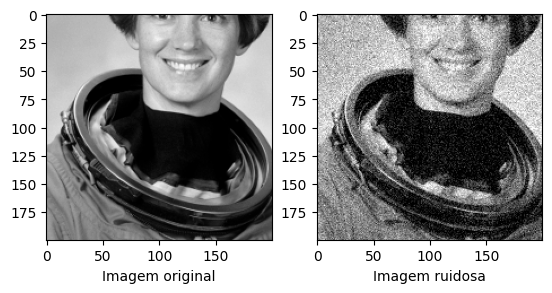

In [4]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

plt.set_cmap('gray')
plt.figure()

plt.subplot(1, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(1, 2, 2)
plt.xlabel('Imagem ruidosa')
plt.imshow(im_nse)
plt.show()

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 1.52 s, sys: 176 µs, total: 1.52 s
Wall time: 1.52 s


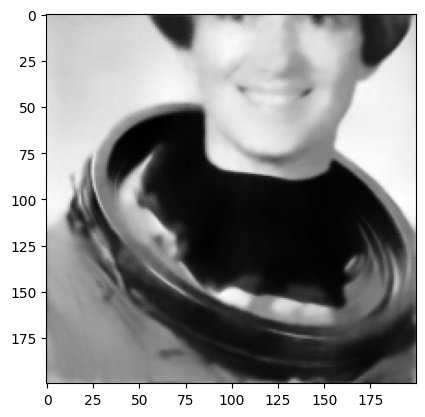

In [5]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1)

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 10 s, sys: 688 ms, total: 10.7 s
Wall time: 10.8 s


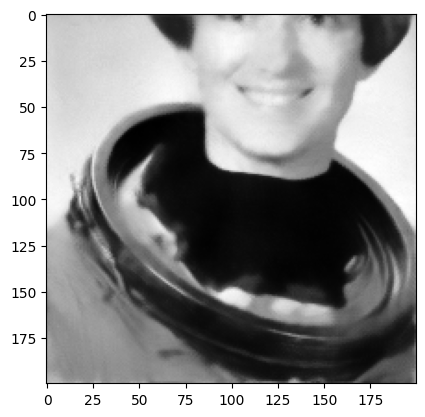

In [6]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (CPRR)
This denoise the image using CPRR as the reranking method.

CPU times: user 10.9 s, sys: 863 ms, total: 11.8 s
Wall time: 24.7 s


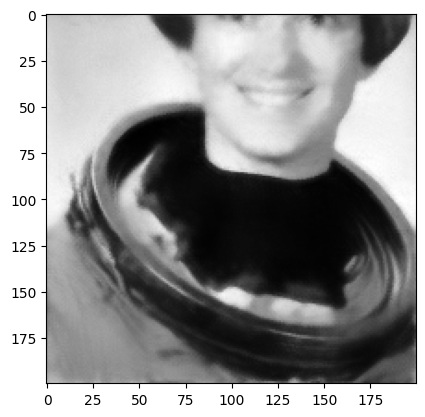

In [7]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2)

### Show the images side by side

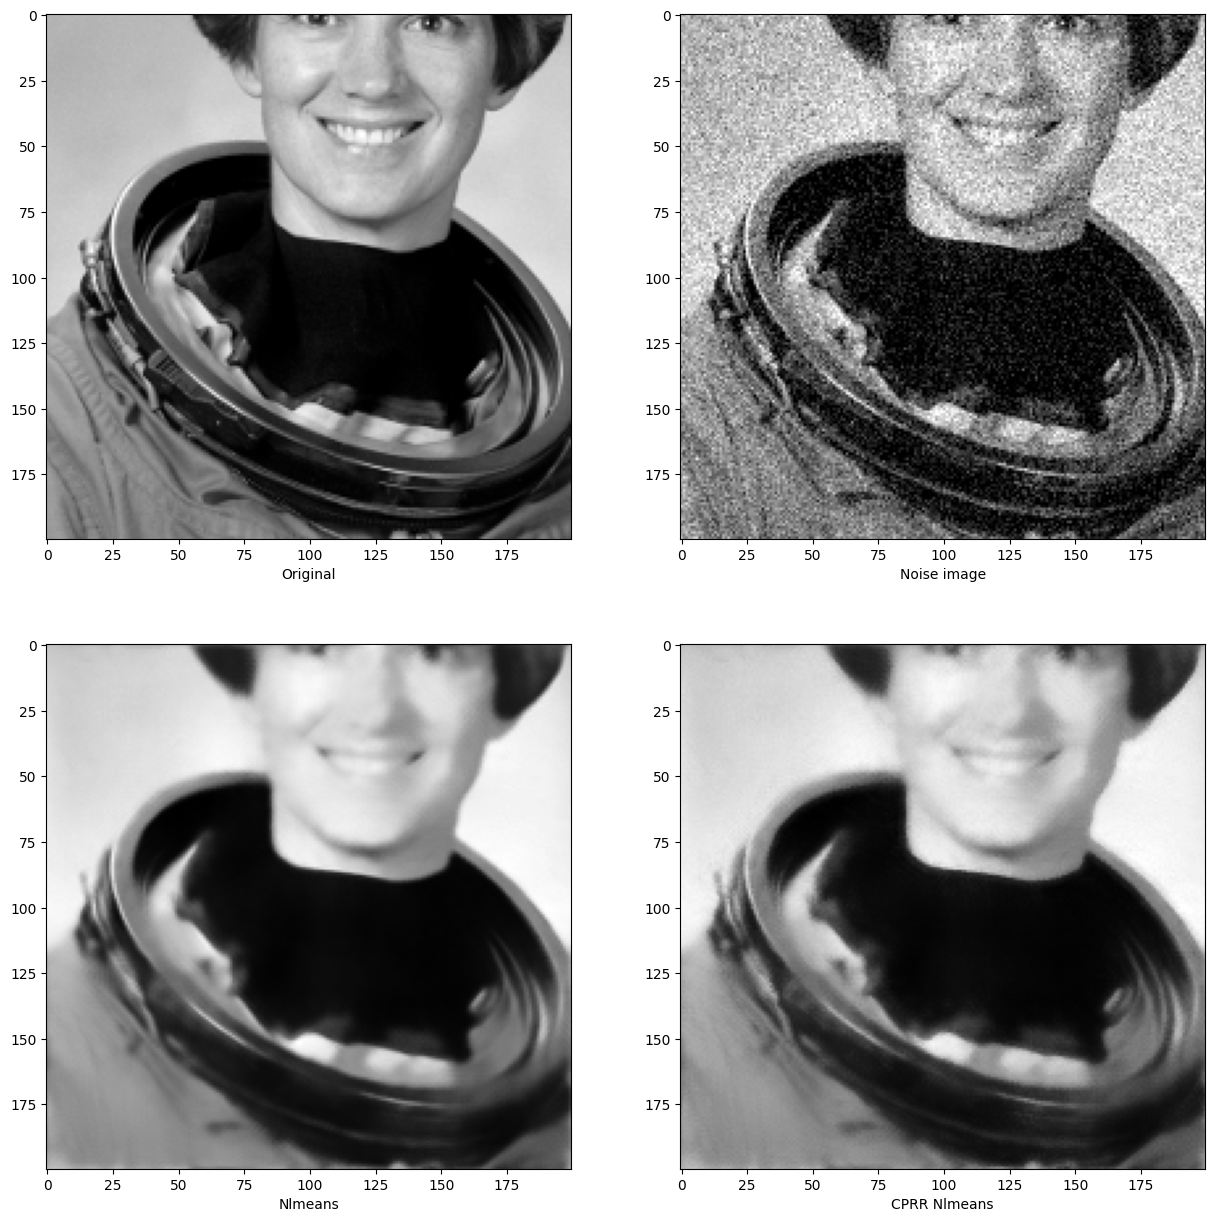

Noise    Nlmeans  CPRR Nlmeans  NONE Nlmeans
PSNR  20.582626  23.142633     22.879415     23.327438
SSIM   0.450165   0.679699      0.673141      0.687343
MSE    0.008745   0.003362      0.003598      0.003233

In [8]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K

In [9]:
%%time
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 22
end      = 32
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k   = start
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k   = k
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k': 3, 't': 1}	22.879415365658808
{'k': 4, 't': 1}	22.688420515098326
{'k': 5, 't': 1}	22.48700538043982
{'k': 6, 't': 1}	22.399552535348608
{'k': 7, 't': 1}	22.345967490664613
{'k': 8, 't': 1}	22.369491286279896
{'k': 9, 't': 1}	22.37359042561109
{'k': 10, 't': 1}	22.352042213451778
{'k': 11, 't': 1}	22.377111067295505
{'k': 12, 't': 1}	22.373079394166865
{'k': 13, 't': 1}	22.41125155067031
{'k': 14, 't': 1}	22.358708694684548
{'k': 15, 't': 1}	22.393076479857097
{'k': 16, 't': 1}	22.42401855814071
{'k': 17, 't': 1}	22.495240044667646
{'k': 18, 't': 1}	22.5016061819939
{'k': 19, 't': 1}	22.4604447581094
{'k': 20, 't': 1}	22.477554404195665
{'k': 21, 't': 1}	22.55160813577772
{'k': 22, 't': 1}	22.533841894434307
{'k': 23, 't': 1}	22.519072409787654
{'k': 24, 't': 1}	22.53899079221107
{'k': 25, 't': 1}	22.539098408500916
{'k': 26, 't': 1}	22.582977959084044
{'k': 27, 't': 1}	22.506115894995506
{'k': 28, 't': 1}	22.545010626164537
{'k': 29, 't': 1}	22.507416112560644
{'k': 30, 't': 1}	

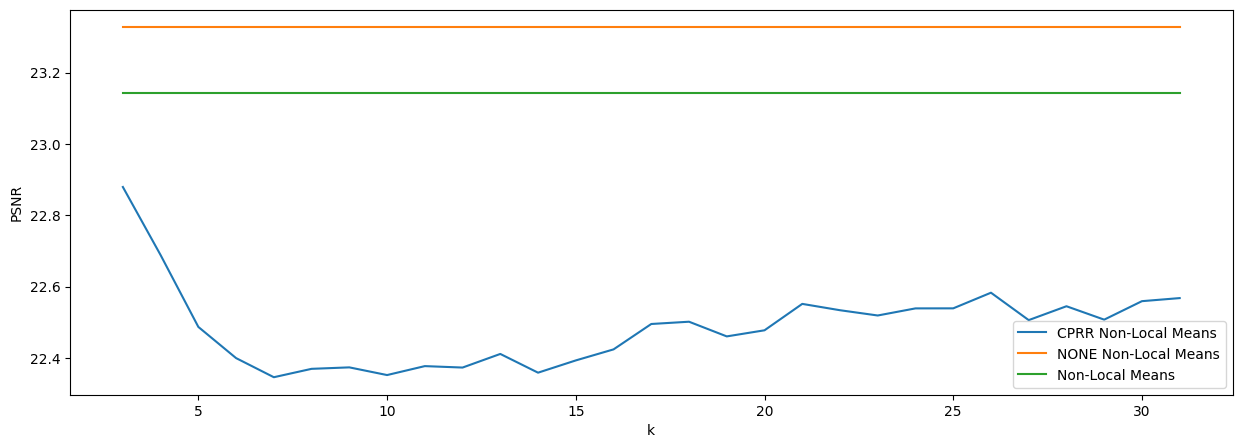

In [10]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, 'k_tuning_plot.png'))

### T

In [11]:
%%time
start    = 1
end      = 10
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
best_t = start

for i, t in enumerate(possible_values):
    udl_params['t'] = t
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_t = t
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', t)
        break
        
# Update method parameters
udl_params['t'] = best_t
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k': 3, 't': 1}	22.879415365658808
{'k': 3, 't': 2}	22.87061752873157
{'k': 3, 't': 3}	22.92684175658103
{'k': 3, 't': 4}	22.925300640738925
{'k': 3, 't': 5}	22.92491480580071
{'k': 3, 't': 6}	22.923740225963208
{'k': 3, 't': 7}	22.92390650068728
{'k': 3, 't': 8}	22.92388943202549
{'k': 3, 't': 9}	22.923906590543638

Final params:
{'k': 3, 't': 3}	22.92684175658103
CPU times: user 1min 38s, sys: 6.87 s, total: 1min 45s
Wall time: 3min 48s


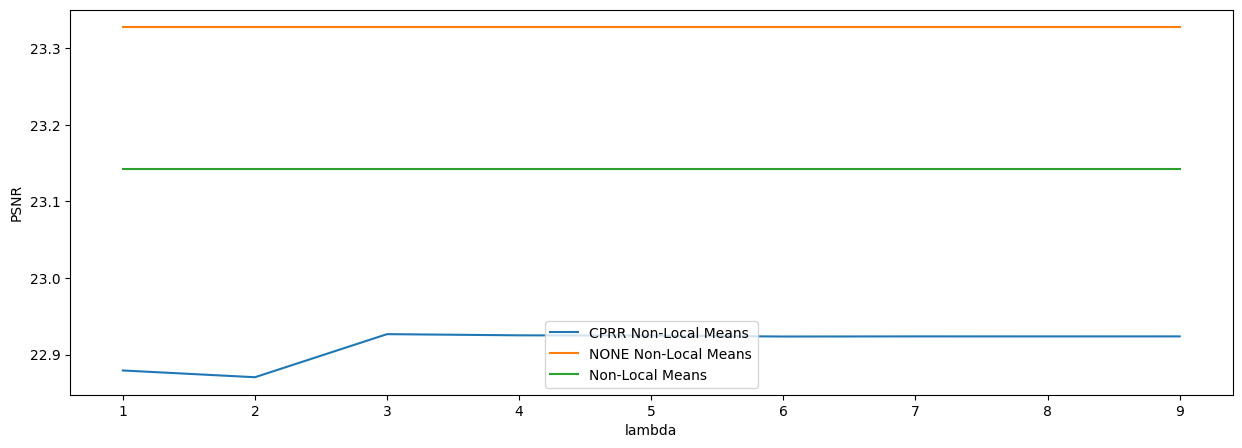

In [12]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('lambda')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, 't_tuning_plot.png'))

### Final Result

In [13]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE'],
)

Noise    Nlmeans       CPRR       NONE
PSNR  20.582626  23.142633  22.926842  23.327438
SSIM   0.450165   0.679699   0.673615   0.687343
MSE    0.008745   0.003362   0.003605   0.003233

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [14]:
%%time
import sys

eval_info = []
eval_psnr = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 

    # Save the images if requested
    if save_data:
        plt.imsave(os.path.join(out_dir, f'{image}.png'), im)
        plt.imsave(os.path.join(out_dir, f'{image}_noise.png'), im_nse)
        plt.imsave(os.path.join(out_dir, f'{image}_nlm.png'), im_fil1)
        plt.imsave(os.path.join(out_dir, f'{image}_{udl_method}.png'), im_fil2)
        plt.imsave(os.path.join(out_dir, f'{image}_NONE.png'), im_fil3)

    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape, im.dtype)

Method: CPRR
Parameters: {'k': 3, 't': 3}
Tested with image: astronaut (200, 200) float64
Tested with image: binary_blobs (200, 200) float64
Tested with image: brick (200, 200) float64
Tested with image: camera (200, 200) float64
Tested with image: cat (200, 200) float64
Tested with image: checkerboard (200, 200) float64
Tested with image: clock (200, 200) float64
Tested with image: coffee (200, 200) float64
Tested with image: coins (200, 200) float64
Tested with image: eagle (200, 200) float64
Tested with image: grass (200, 200) float64
Tested with image: gravel (200, 200) float64
Tested with image: horse (200, 200) float64
Tested with image: page (191, 191) float64
Tested with image: text (172, 172) float64
Tested with image: rocket (200, 200) float64
CPU times: user 6min 7s, sys: 23.1 s, total: 6min 30s
Wall time: 9min 56s


### Results

In [15]:
results_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params)
print('Number of images tested:', len(results_df))
results_df.style.apply(highlight_best_values, axis=1)

CPRR {'k': 3, 't': 3}
Number of images tested: 16


In [16]:
results_df[results_df[udl_method] > results_df['Nlmeans']]

Noise    Nlmeans       CPRR       NONE
cat  20.010958  22.303322  22.349387  22.572579

In [17]:
if save_data:
    import json
    results_df.to_csv(os.path.join(out_dir, 'results.csv'))
    with open(os.path.join(out_dir, 'params.json'), 'w') as fp:
        json.dump({
            'hP': hP,
            'hW': hW,
            'tau': tau,
            'sig': sig,
            'shape': shape,
            'n_w': n_w,
            'seed': seed,
            'udl_method': udl_method,
            'udl_params': udl_params,
            'tuning_method': 'simple'
        }, fp)

# Experiments with 'square' shape

## Parameters

In [18]:
image = 'astronaut'
shape = 'square'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

CPRR {'k': 3, 't': 1}


In [19]:
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

./output/final_tests/CPRR_42/square


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

In [20]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

## Initial execution

Executes the original NLM, NLM-UDLF and NLM-NONE for the image, only changing the shape parameter.

In [21]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

CPU times: user 1.99 s, sys: 78 µs, total: 1.99 s
Wall time: 1.99 s


In [22]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()

CPU times: user 13.7 s, sys: 956 ms, total: 14.6 s
Wall time: 14.7 s


In [23]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()

CPU times: user 15.1 s, sys: 1.26 s, total: 16.4 s
Wall time: 31.5 s


### Initial result

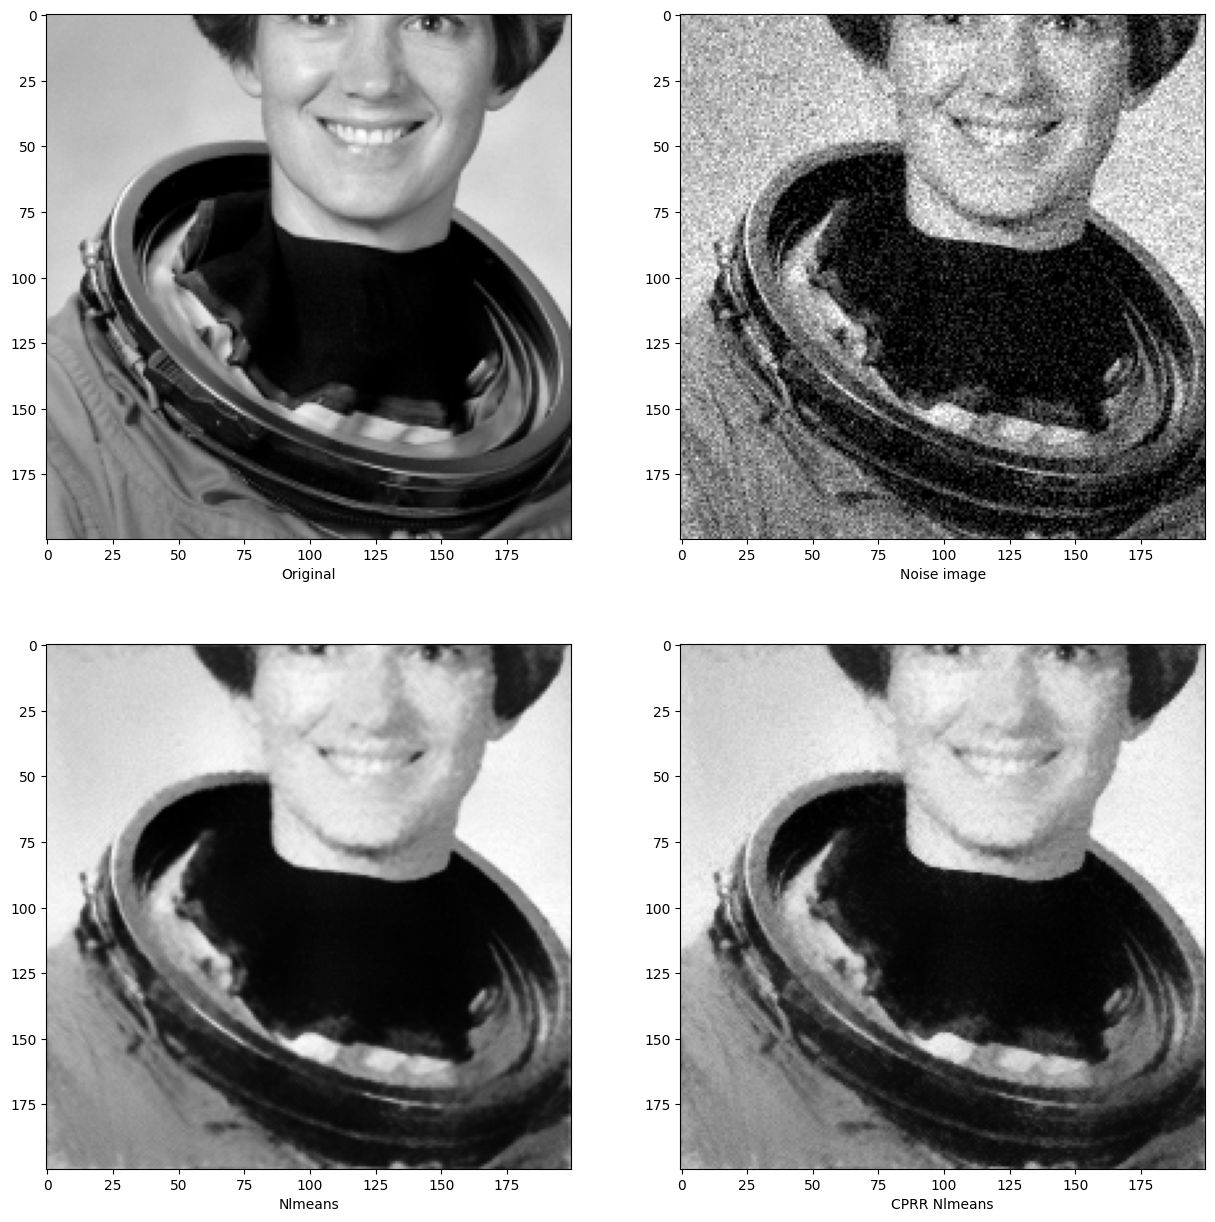

Noise    Nlmeans  CPRR Nlmeans  NONE Nlmeans
PSNR  20.582626  24.478626     24.398327     24.560339
SSIM   0.450165   0.720574      0.696828      0.705158
MSE    0.008745   0.002515      0.002624      0.002504

In [24]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K

In [25]:
%%time
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 22
end      = 32
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k   = start
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k   = k
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k': 3, 't': 1}	24.3983265750555
{'k': 4, 't': 1}	24.241809794666928
{'k': 5, 't': 1}	24.16025683862125
{'k': 6, 't': 1}	24.085764378898716
{'k': 7, 't': 1}	24.03918622385019
{'k': 8, 't': 1}	24.018507493912157
{'k': 9, 't': 1}	23.996828658248607
{'k': 10, 't': 1}	24.007162372180566
{'k': 11, 't': 1}	23.993232854578586
{'k': 12, 't': 1}	23.97996022036402
{'k': 13, 't': 1}	24.010836108523183
{'k': 14, 't': 1}	23.950115690711094
{'k': 15, 't': 1}	23.981664235655575
{'k': 16, 't': 1}	23.99228136328372
{'k': 17, 't': 1}	23.980310397582436
{'k': 18, 't': 1}	23.979717282478834
{'k': 19, 't': 1}	23.940053953407038
{'k': 20, 't': 1}	24.0052749039562
{'k': 21, 't': 1}	23.990688238651412
{'k': 22, 't': 1}	23.95773526834846
{'k': 23, 't': 1}	24.008579364342424
{'k': 24, 't': 1}	23.988840586522056
{'k': 25, 't': 1}	23.994019011277015
{'k': 26, 't': 1}	24.00803552234361
{'k': 27, 't': 1}	23.977308695800225
{'k': 28, 't': 1}	24.038527541018397
{'k': 29, 't': 1}	23.99038249408762
{'k': 30, 't': 1}	2

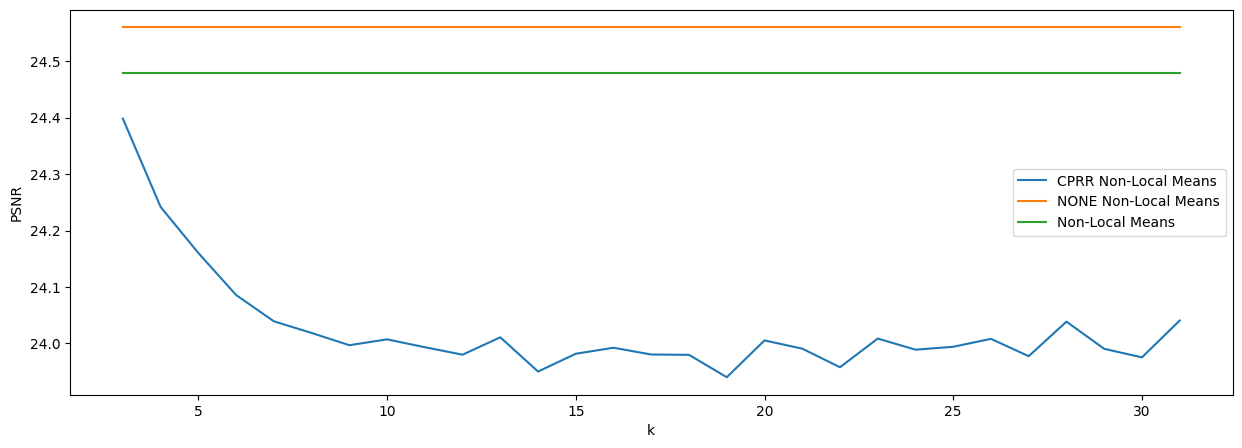

In [26]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, f'k_tuning_plot.png'))

### T

In [27]:
%%time
start    = 1
end      = 10
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
best_t = start

for i, t in enumerate(possible_values):
    udl_params['t'] = t
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_t = t
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', t)
        break
        
# Update method parameters
udl_params['t'] = best_t
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k': 3, 't': 1}	24.3983265750555
{'k': 3, 't': 2}	24.3986261050393
{'k': 3, 't': 3}	24.388350406153556
{'k': 3, 't': 4}	24.389876019975834
{'k': 3, 't': 5}	24.39012012939998
{'k': 3, 't': 6}	24.390193785203035
{'k': 3, 't': 7}	24.390290140301907
{'k': 3, 't': 8}	24.39024487117917
{'k': 3, 't': 9}	24.390223990324248

Final params:
{'k': 3, 't': 2}	24.3986261050393
CPU times: user 2min 16s, sys: 10.2 s, total: 2min 26s
Wall time: 4min 49s


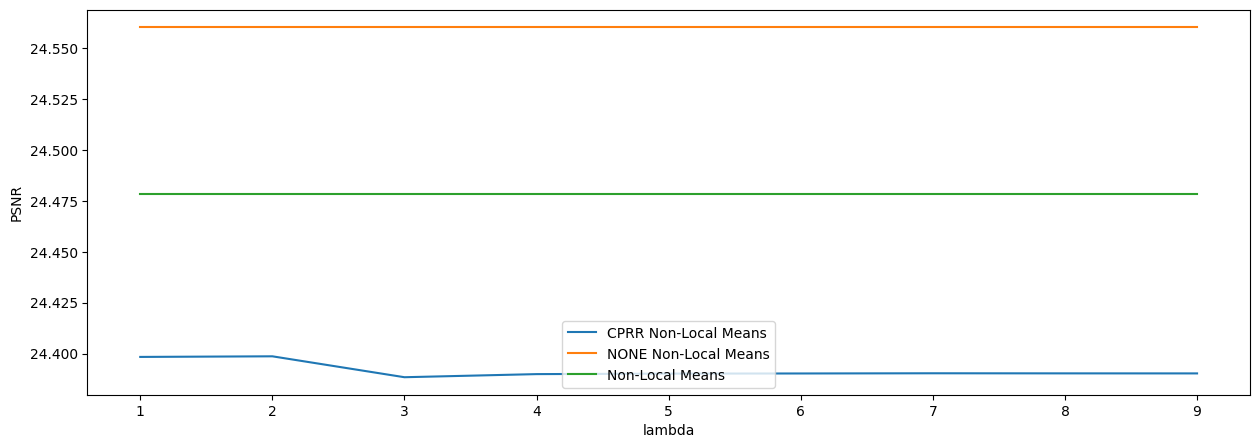

In [28]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('lambda')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, f't_tuning_plot.png'))

### Final Result

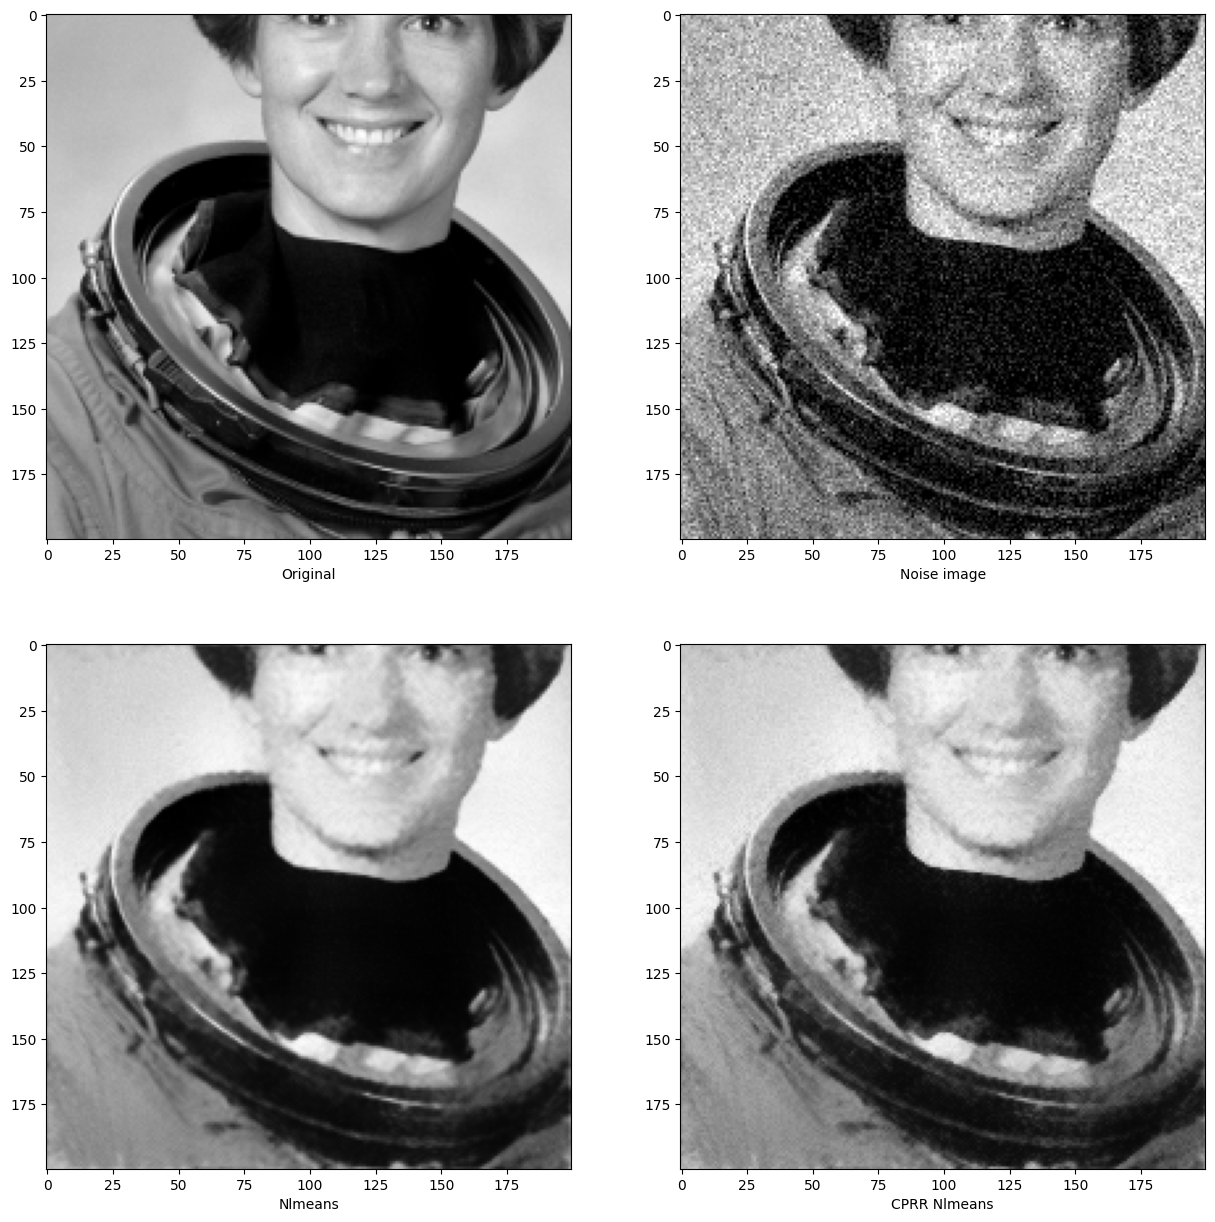

Noise    Nlmeans       CPRR       NONE
PSNR  20.582626  24.478626  24.398626  24.560339
SSIM   0.450165   0.720574   0.696702   0.705158
MSE    0.008745   0.002515   0.002626   0.002504

In [29]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [30]:
%%time
import sys

eval_info = []
eval_psnr = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 

    # Save the images if requested
    if save_data:
        plt.imsave(os.path.join(out_dir, f'{image}.png'), im)
        plt.imsave(os.path.join(out_dir, f'{image}_noise.png'), im_nse)
        plt.imsave(os.path.join(out_dir, f'{image}_nlm.png'), im_fil1)
        plt.imsave(os.path.join(out_dir, f'{image}_{udl_method}.png'), im_fil2)
        plt.imsave(os.path.join(out_dir, f'{image}_NONE.png'), im_fil3)
                   
    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape, im.dtype)

Method: CPRR
Parameters: {'k': 3, 't': 2}
Tested with image: astronaut (200, 200) float64
Tested with image: binary_blobs (200, 200) float64
Tested with image: brick (200, 200) float64
Tested with image: camera (200, 200) float64
Tested with image: cat (200, 200) float64
Tested with image: checkerboard (200, 200) float64
Tested with image: clock (200, 200) float64
Tested with image: coffee (200, 200) float64
Tested with image: coins (200, 200) float64
Tested with image: eagle (200, 200) float64
Tested with image: grass (200, 200) float64
Tested with image: gravel (200, 200) float64
Tested with image: horse (200, 200) float64
Tested with image: page (191, 191) float64
Tested with image: text (172, 172) float64
Tested with image: rocket (200, 200) float64
CPU times: user 8min 26s, sys: 32.9 s, total: 8min 59s
Wall time: 12min 58s


### Results

In [31]:
results_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params)
print('Number of images tested:', len(results_df))
results_df.style.apply(highlight_best_values, axis=1)
#pd.DataFrame(
#    data    = eval_info,
#    index   = images,
#    columns = ['PSNR Noise', 'SSIM Noise', 'MSE Noise', 
#               'PSNR Nlmeans', 'SSIM Nlmeans', 'MSE Nlmeans',
#               'PSNR RL-RECOM Nlmeans', 'SSIM RL-RECOM Nlmeans', 'MSE RL-RECOM Nlmeans',
#               'PSNR NONE Nlmeans', 'SSIM NONE Nlmeans', 'MSE NONE Nlmeans']
#)

CPRR {'k': 3, 't': 2}
Number of images tested: 16


In [32]:
results_df[results_df[udl_method] > results_df['Nlmeans']]

Noise    Nlmeans       CPRR       NONE
binary_blobs  22.937413  27.988555  28.116700  28.181554
grass         19.994935  18.347285  18.390156  18.702643

In [33]:
if save_data:
    import json
    results_df.to_csv(os.path.join(out_dir, 'results.csv'))
    with open(os.path.join(out_dir, 'params.json'), 'w') as fp:
        json.dump({
            'hP': hP,
            'hW': hW,
            'tau': tau,
            'sig': sig,
            'shape': shape,
            'n_w': n_w,
            'seed': seed,
            'udl_method': udl_method,
            'udl_params': udl_params,
            'tuning_method': 'simple'
        }, fp)